# Training Dataset

We used the historical dataset from the NASA MCD14DL data collection that is specialized for fire detection (https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/c6-mcd14dl#ed-firms-attributes). However, the quality of the labelling of this dataset is unkown, so we cross referenced the MODIS historical data with two other records of US wildfires.

In [13]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
mh = pd.read_pickle('~/datascience/burn notice/Data-Science/Data/Cleaned_Modus_Historical/clean_historical_modis.pkl')

In [14]:
# extract date range from historical modis
mh['acq_date'] =pd.to_datetime(mh['acq_date'])
mh['acq_date'].sort_values()
mh['acq_date'][:1], mh['acq_date'][-1:]

(0   2001-01-01
 Name: acq_date, dtype: datetime64[ns], 1780523   2016-01-01
 Name: acq_date, dtype: datetime64[ns])

Our historical modis operations are between 2001-01-01 and 2016-01-01. We will extract the exact same date range from our kaggle labelled fires SQL database.

We also filter for fires greater than 200 acres so that we only are sampling fires that have the ability to be seen by modus (resolution is 1x1km on average so we are assuming that the majority of the km should be on fire for optimal detection training)

In [18]:
# FPA FOD data from here: https://www.kaggle.com/rtatman/188-million-us-wildfires
# Create the connection
cnx = sqlite3.connect('/home/nedderlander/datascience/burn notice/Data-Science/Data/FPA_FOD_20170508.sqlite')

# create the dataframe from a query
# Fire Program Analysis (FPA) system
kdf = pd.read_sql_query("""SELECT LATITUDE, LONGITUDE, DISCOVERY_DATE, FIRE_YEAR, FIRE_SIZE,
                       FIRE_SIZE_CLASS, DISCOVERY_DOY FROM Fires WHERE FIRE_YEAR > 2001 AND FIRE_SIZE > 200""", cnx)

In [19]:
kdf.head()

,LATITUDE,LONGITUDE,DISCOVERY_DATE,FIRE_YEAR,FIRE_SIZE,FIRE_SIZE_CLASS,DISCOVERY_DOY
0,38.523333,-120.211667,2453284.5,2004,16823.0,G,280
1,38.780000,-120.260000,2453291.5,2004,7700.0,G,287
2,33.723333,-111.275000,2453542.5,2005,16100.0,G,172
3,35.688056,-118.438333,2453560.5,2005,1149.0,F,190
4,33.933611,-111.379722,2453567.5,2005,1300.0,F,197


In [20]:
kdf['FIRE_SIZE_CLASS'].value_counts()

E    8744
F    4929
D    3814
G    2584
Name: FIRE_SIZE_CLASS, dtype: int64

In [21]:
kdf.shape

(20071, 7)

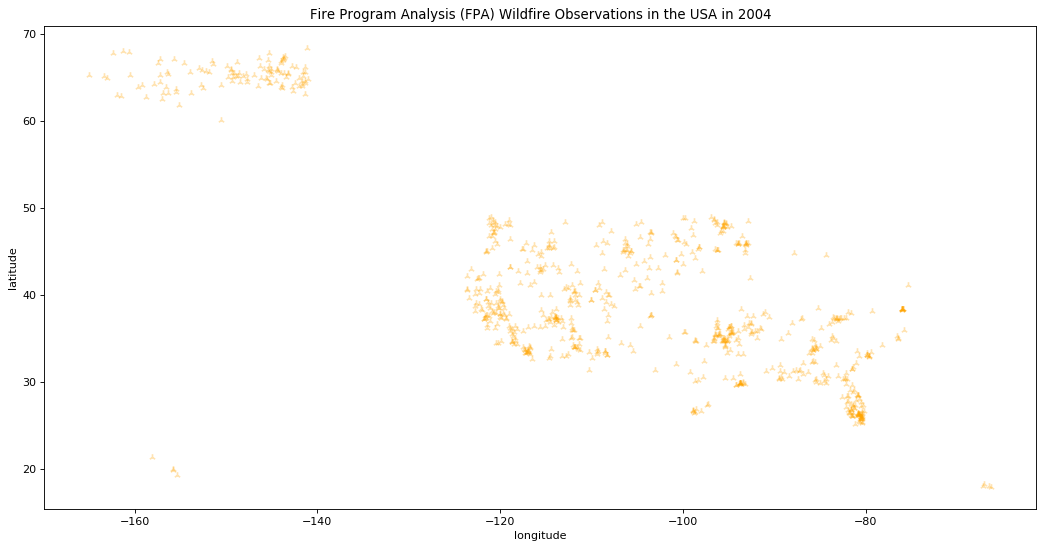

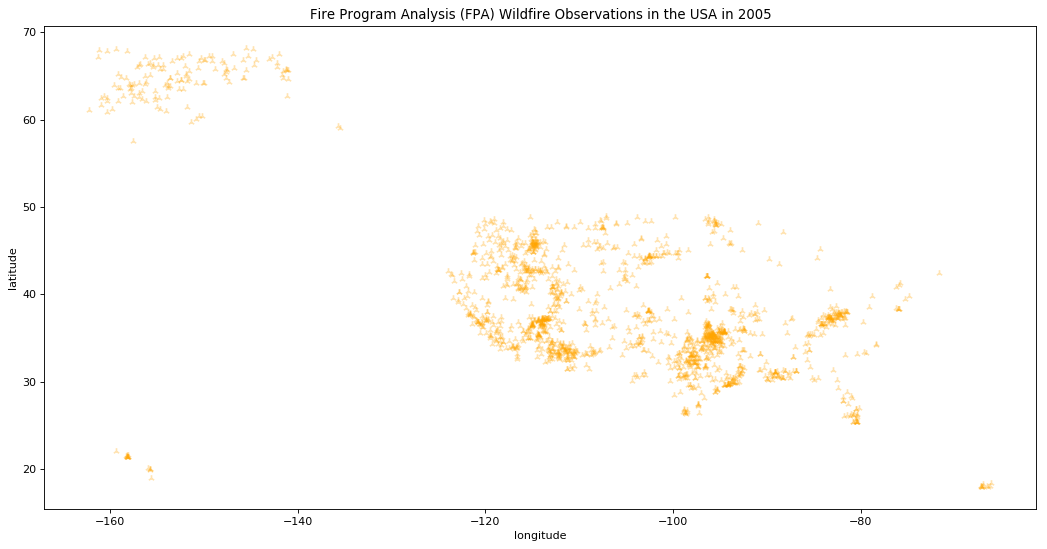

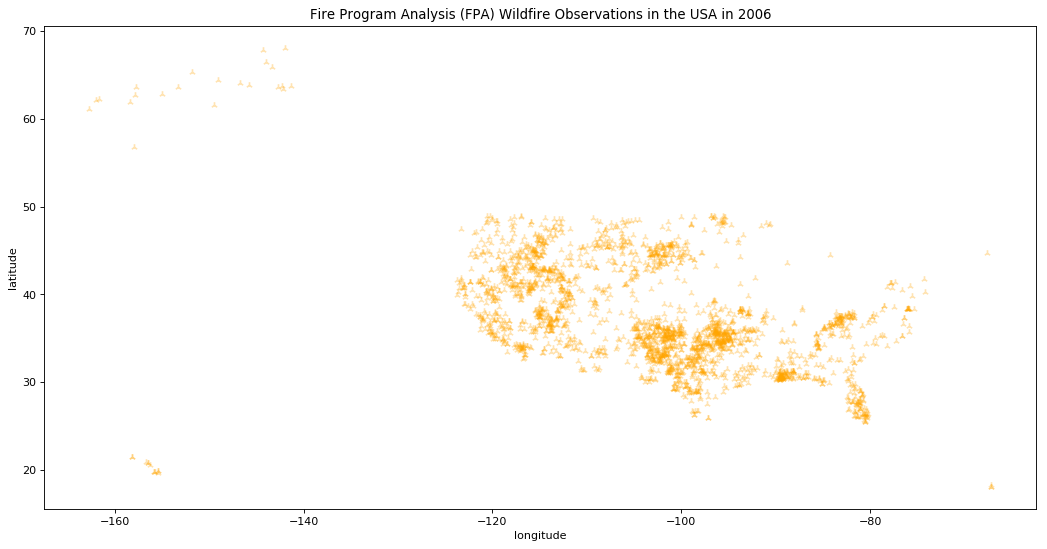

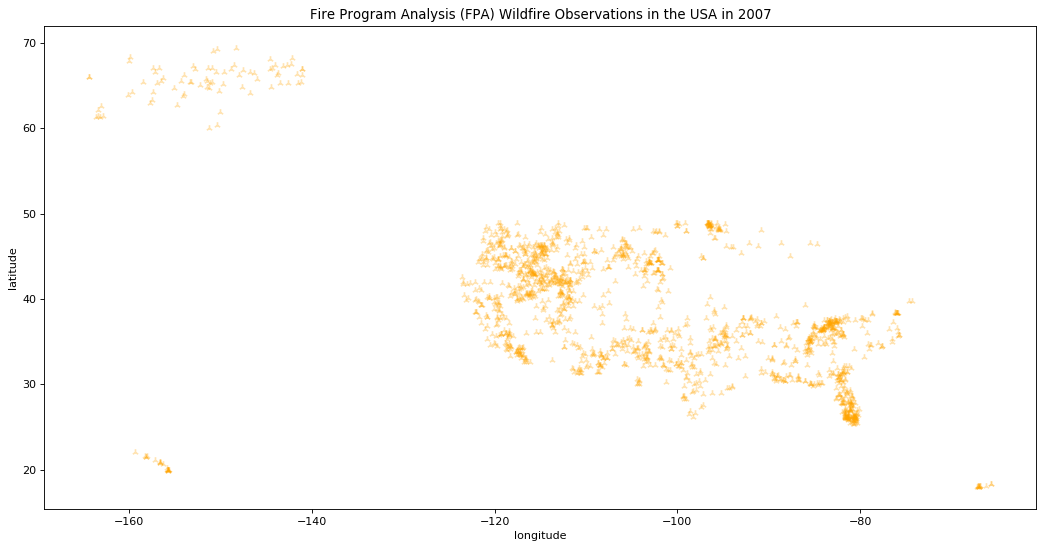

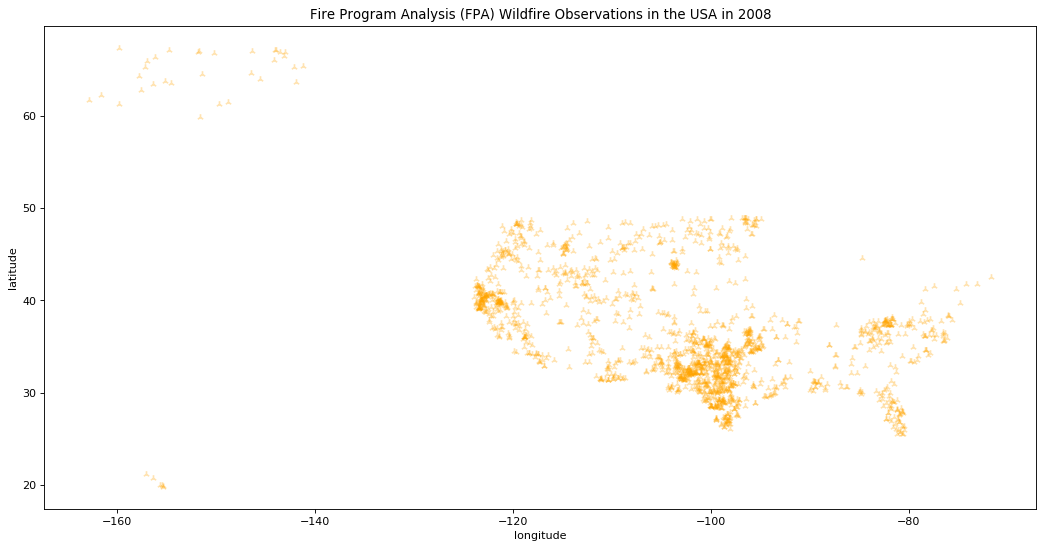

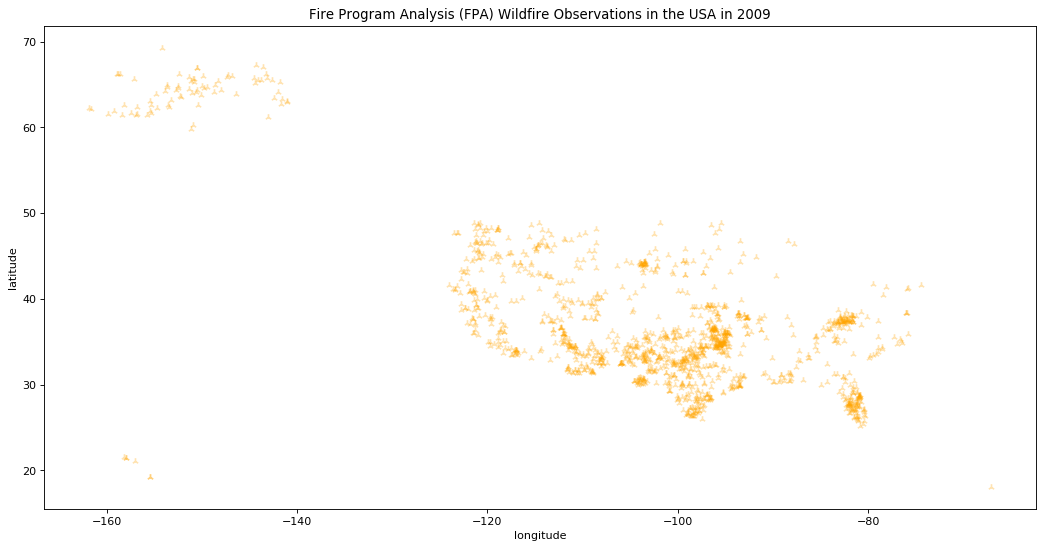

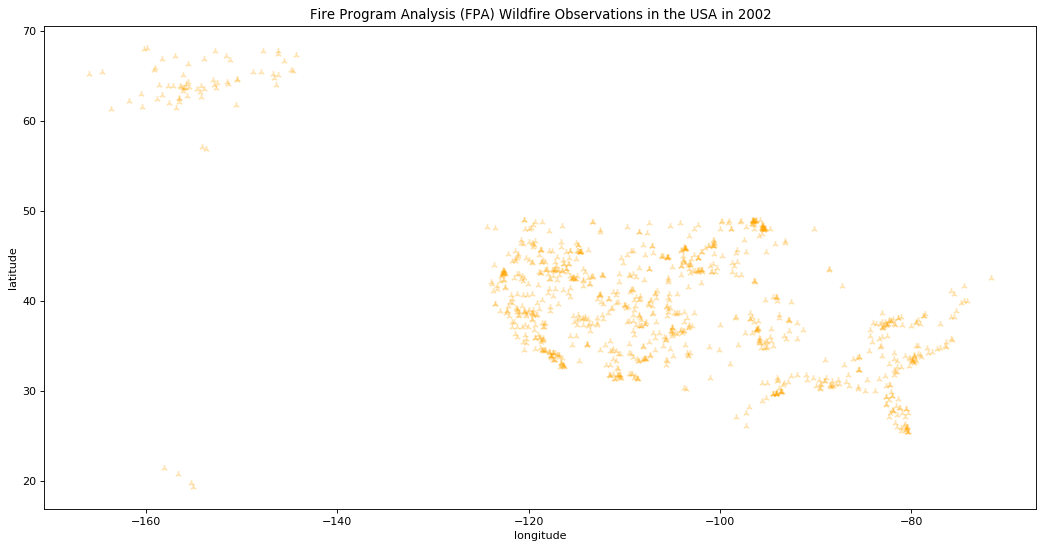

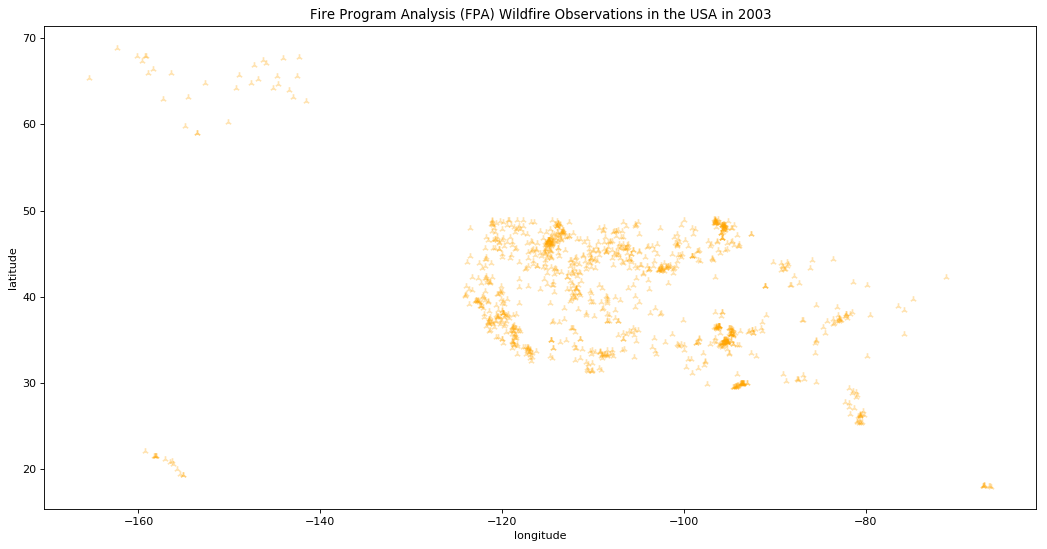

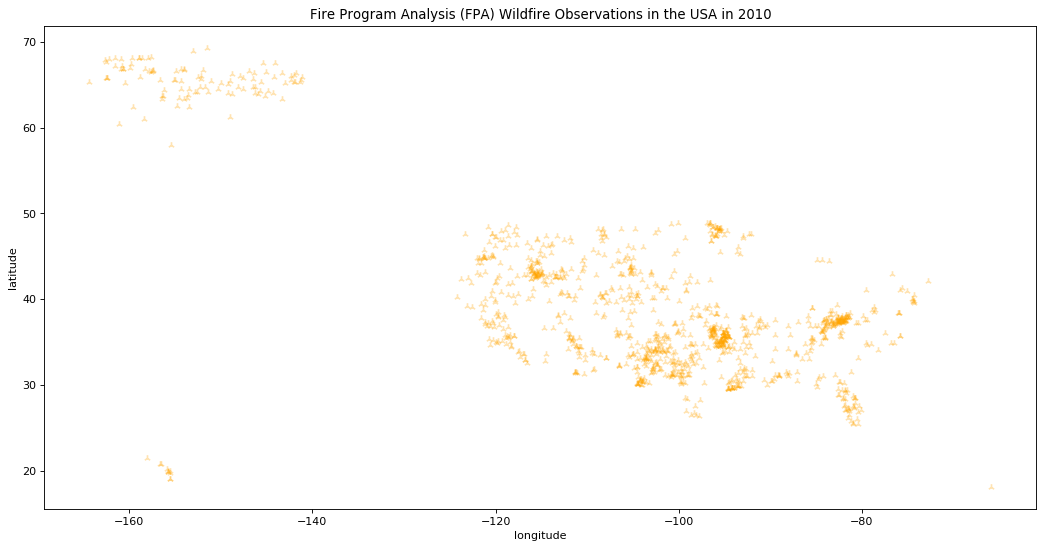

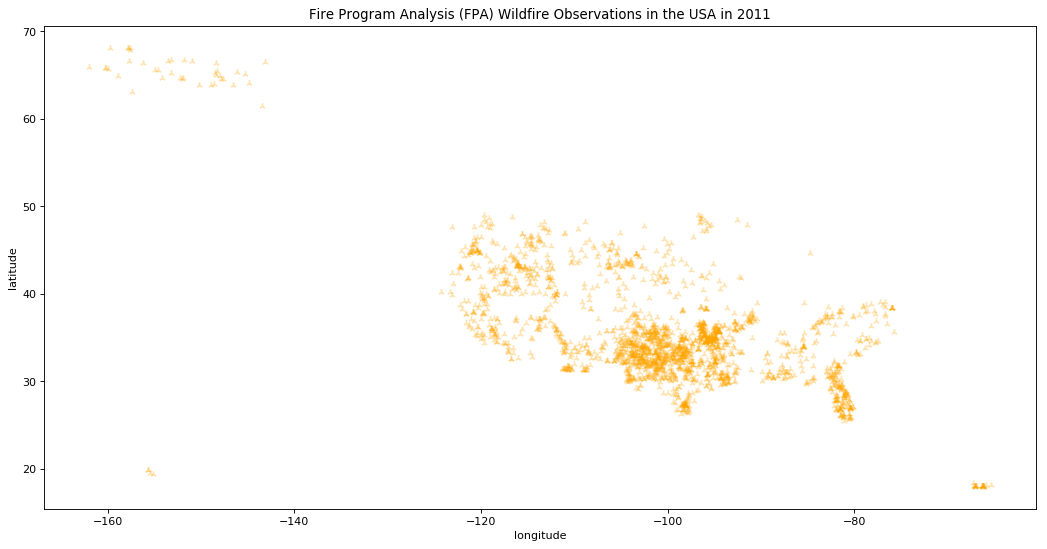

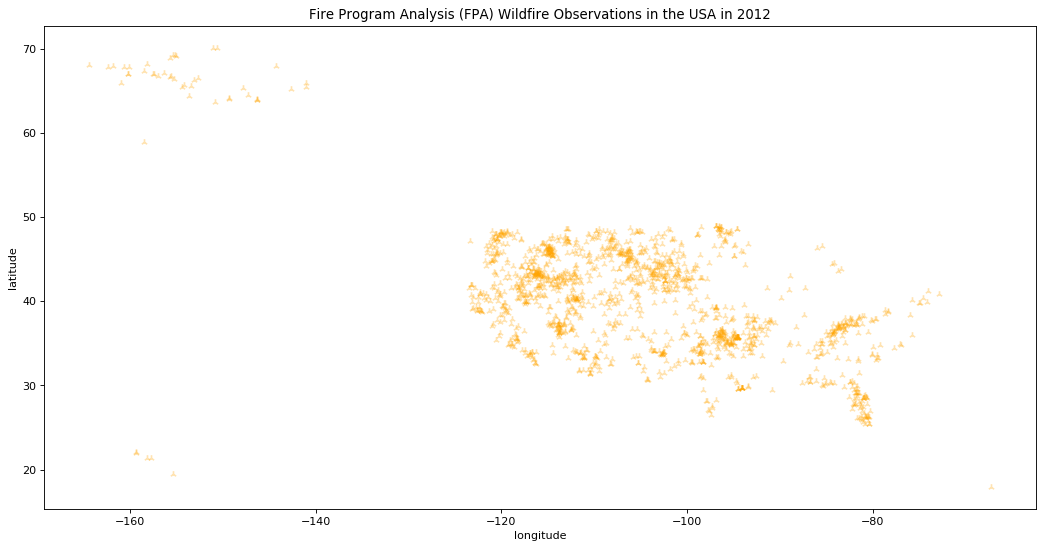

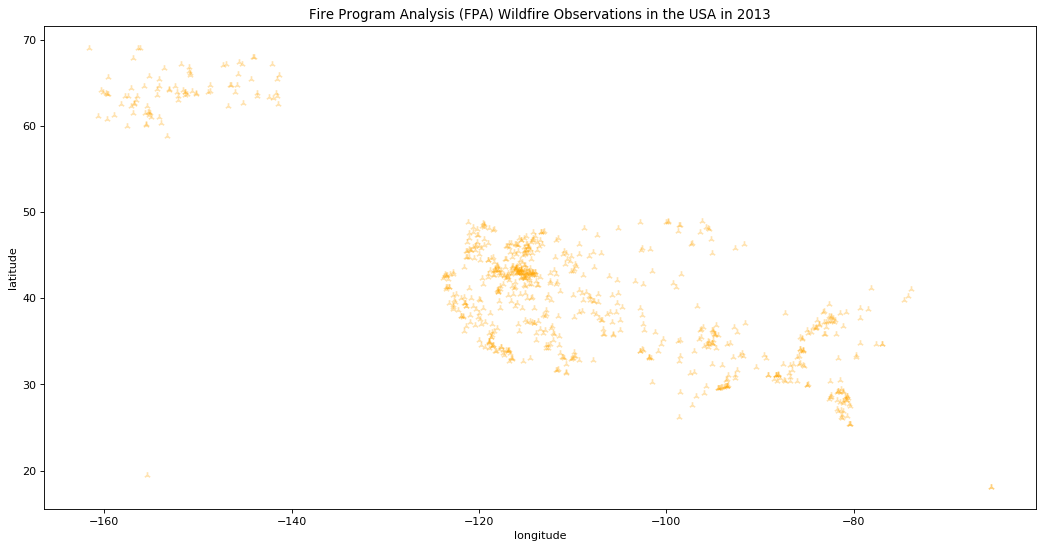

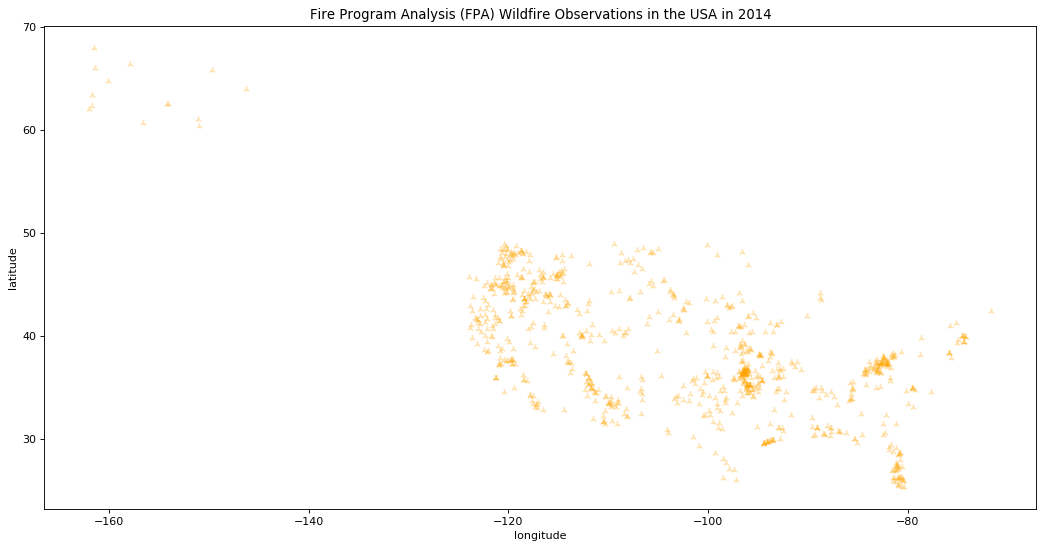

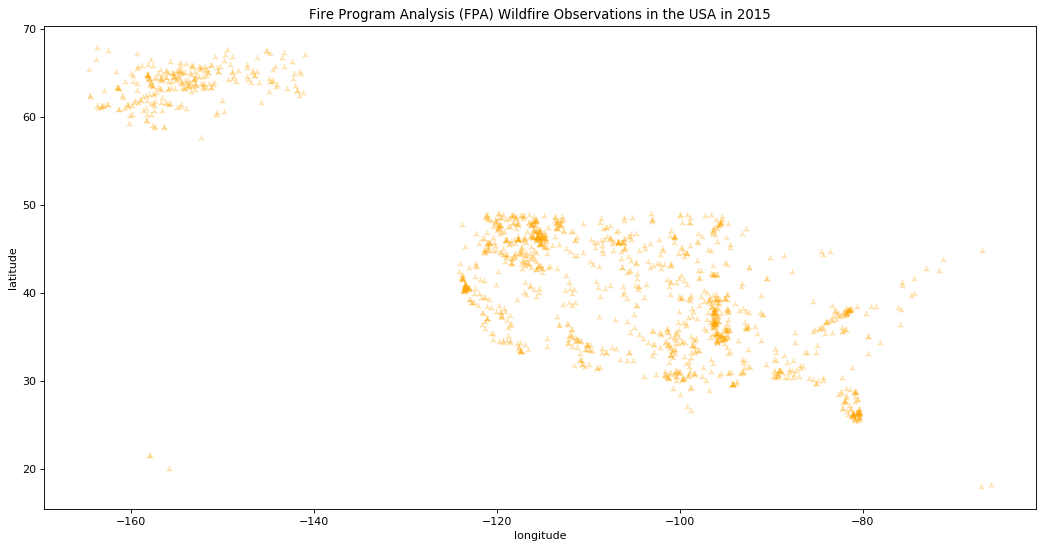

In [23]:
coords = ['LATITUDE', 'LONGITUDE']


years = kdf['FIRE_YEAR'].unique().tolist()

for year in years:
    
    fig, ax = plt.subplots(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
    
    mask = (kdf['FIRE_YEAR'] == year)
    data = kdf[mask][coords]
    title = 'Fire Program Analysis (FPA) Wildfire Observations in the USA in '+str(year)
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title(title)
    
    ax.scatter(data["LONGITUDE"], data["LATITUDE"], alpha=.3, marker="2", color="orange")
    plt.show();

This database shows a huge number of wildfires, so many that it's almost hard to believe that these numbers can be correct. That said, the size of the fire is very relative, so this includes small fires, also, the pixel size of the map biases us into thinking every fire is quite large, when in fact, we're dealing with a huge geographic area. That said, it's hard to know the ground truth of this data so we will have to treat it as true until additional verification methods become availible. 

This FPA set is a great source for labeling fires but it may be missing 'prescribed burns' which are fires that are intentioinally lit to control forrests. We will try to add in a dataset that includes so-called prescribed burns.

In [24]:
# https://wildfire.cr.usgs.gov/firehistory/ 
# Source for data that includes perscribed burns
fh_path = '/home/nedderlander/datascience/burn notice/Data-Science/Data/fh_all_1980_2016.csv'
fields = ['STARTDATED', 'DLATITUDE', 'DLONGITUDE' , 'YEAR_', 'TOTALACRES']

df = pd.read_csv(fh_path, usecols=fields)

fhf = df[df['TOTALACRES'] > 200]
del(df)
fhf.shape

(31477, 5)

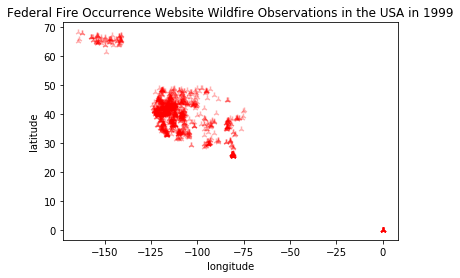

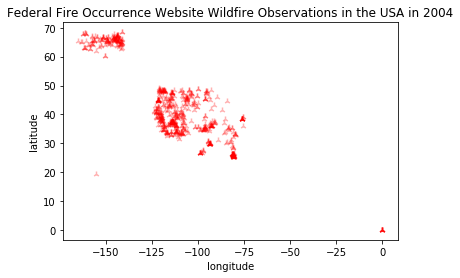

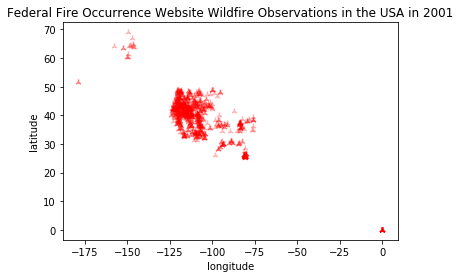

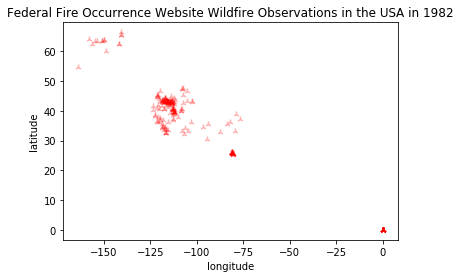

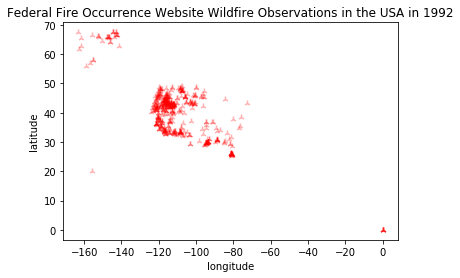

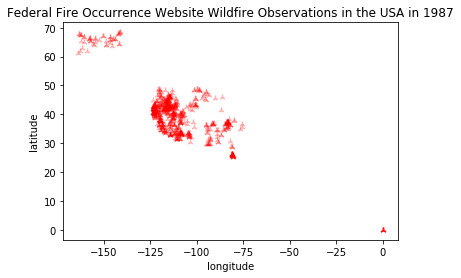

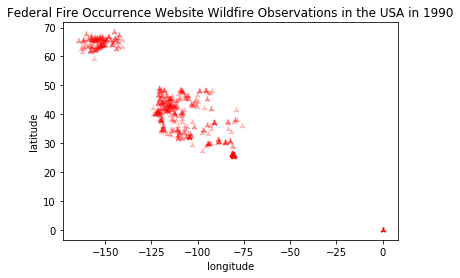

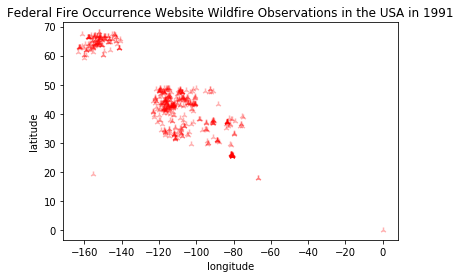

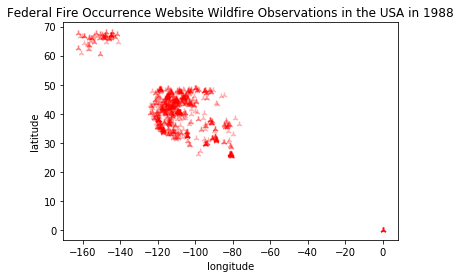

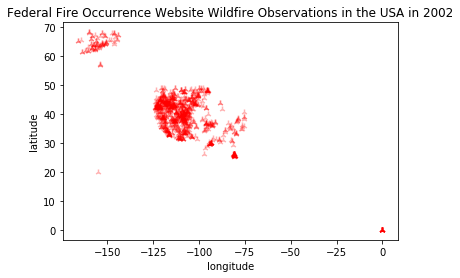

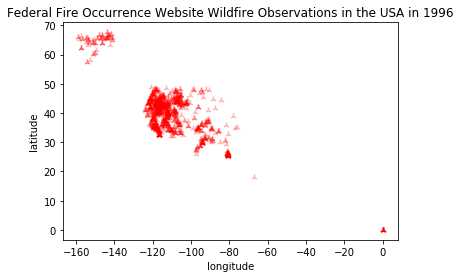

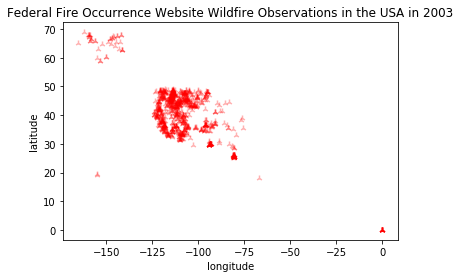

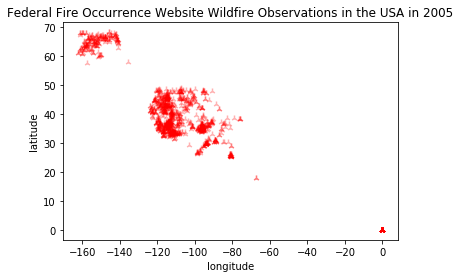

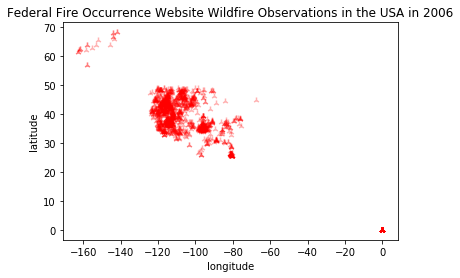

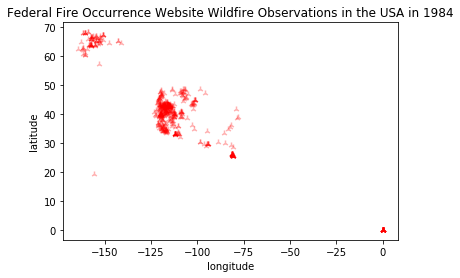

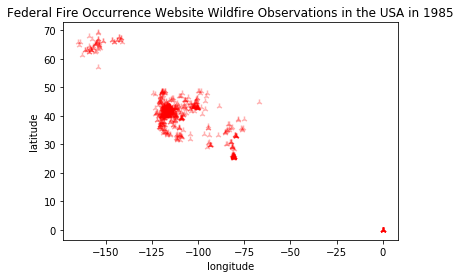

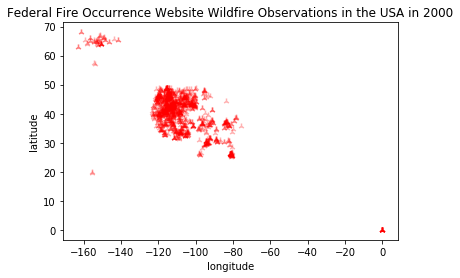

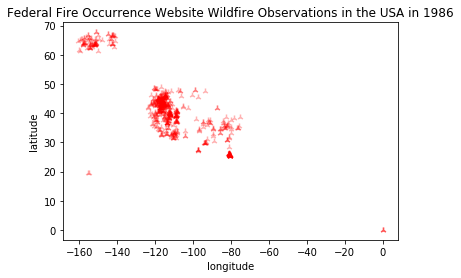

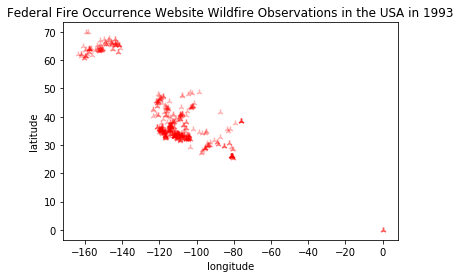

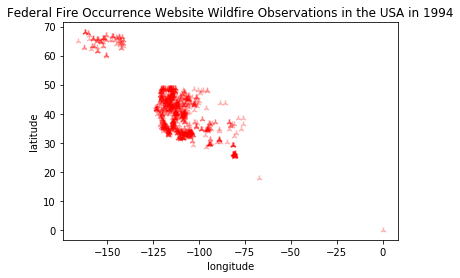

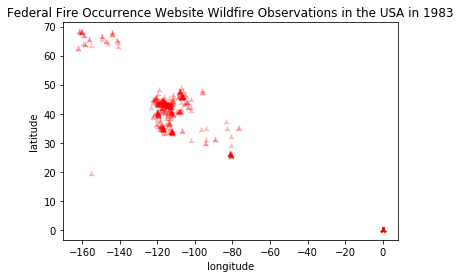

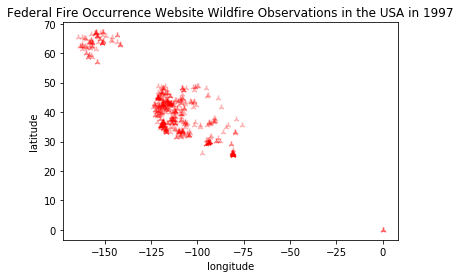

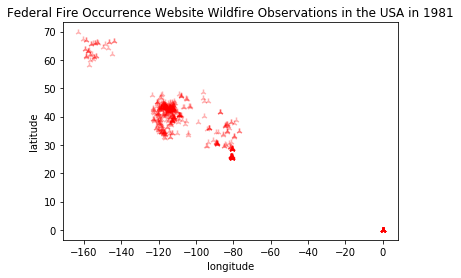

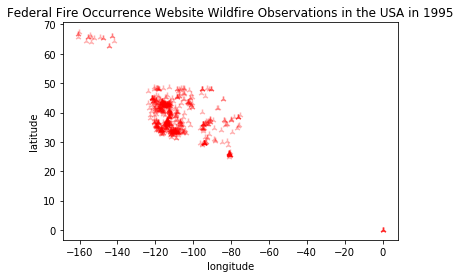

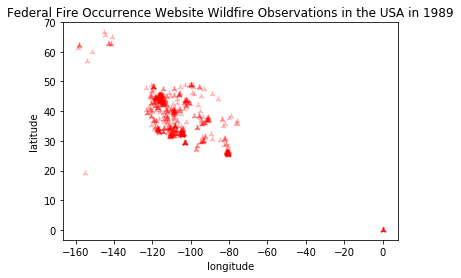

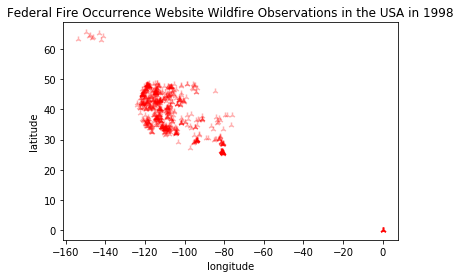

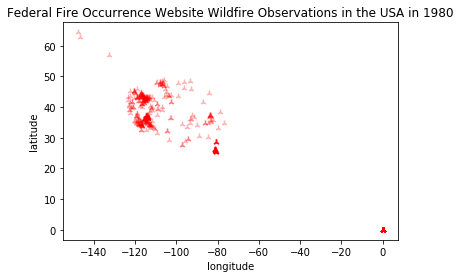

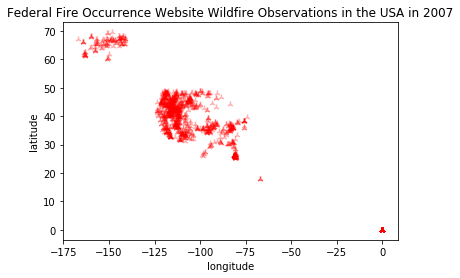

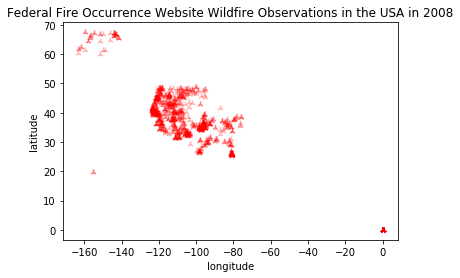

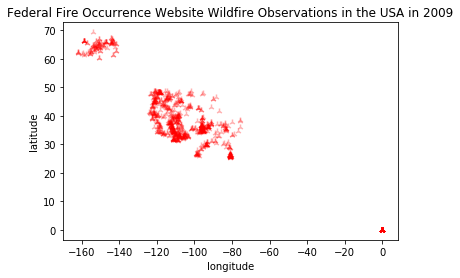

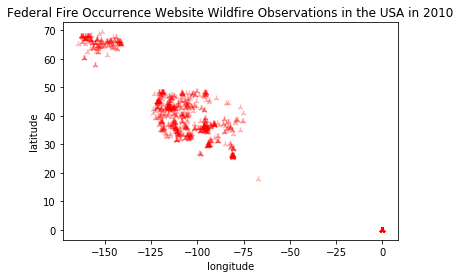

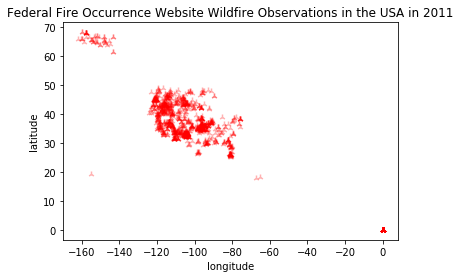

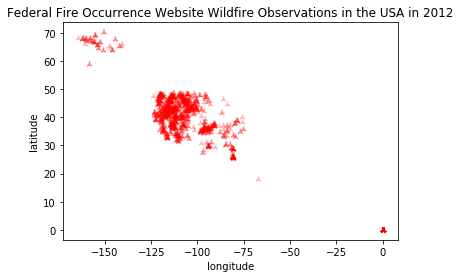

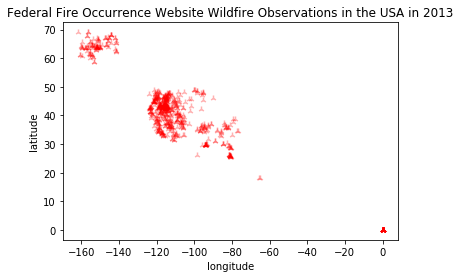

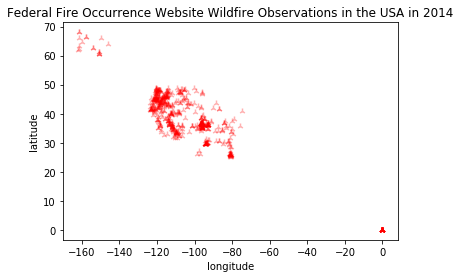

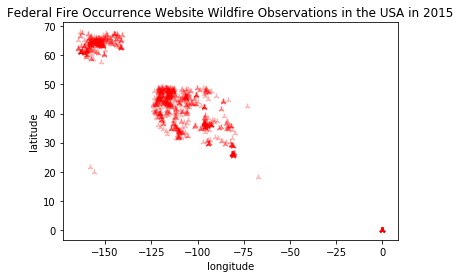

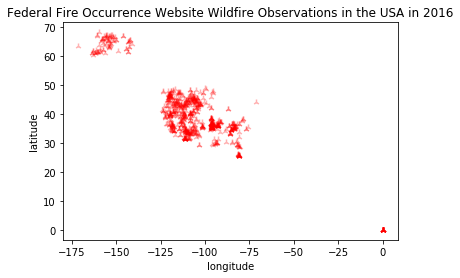

In [26]:
coords = ['DLATITUDE', 'DLONGITUDE']


years = fhf['YEAR_'].unique().tolist()

for year in years:
    
    mask = (fhf['YEAR_'] == year)
    data = fhf[mask][coords]
    title = 'Federal Fire Occurrence Website Wildfire Observations in the USA in '+str(year)
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title(title)
    
    plt.scatter(data["DLONGITUDE"], data["DLATITUDE"], alpha=.3, marker="2", color="red")
#     plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.show();

Now we will match fhf and kdf to hopefully create a more comprehensive labelling source.

This will involve turning the fhf date to datetime, creating a date from the kdf features Fire_year and DOY, and then fuzzy matching dates and rounded longitudes.

In [27]:
# For our kdf

# create datetime objects and then year and month
import datetime

fire_year = kdf["FIRE_YEAR"].tolist()
day_of_year = kdf["DISCOVERY_DOY"].tolist()

fire_dates = tuple(zip(fire_year, day_of_year))

def to_date(fire_dates):
    dates = []
    for row in fire_dates:
        dates.append(datetime.datetime(row[0], 1, 1) + datetime.timedelta(row[1] - 1))
    return dates

dates = to_date(fire_dates)
kdf['DATE'] = dates
kdf['MONTH'] = kdf['DATE'].dt.month
kdf['WEEK'] = kdf['DATE'].dt.weekofyear


# rename FIREYEAR to year for simplicity
kdf = kdf.rename(columns={'FIRE_YEAR' : 'YEAR'})


In [28]:
# now that we have DATE and MONTH for kdf, we will produce the same features for fhf
fhf['STARTDATED'] = fhf['STARTDATED'].str.replace(" ", "")
fhf['DATE'] = pd.to_datetime(fhf['STARTDATED'], format='%Y/%m/%d', errors='coerce')
fhf['MONTH'] = fhf['DATE'].dt.month
fhf['WEEK'] = fhf['DATE'].dt.weekofyear

# rename YEAR_ to year for simplicity
fhf = fhf.rename(columns={'YEAR_' : 'YEAR'})

In [29]:
# now we will create rounded lat/longs and merge these datasets together
dec = 1
fhf["lat_r"] = round(fhf["DLATITUDE"], dec)
fhf["lon_r"] = round(fhf["DLONGITUDE"], dec)
kdf["lat_r"] = round(kdf["LATITUDE"], dec)
kdf["lon_r"] = round(kdf["LONGITUDE"], dec)

rounded = ['lat_r', 'lon_r', 'YEAR', 'MONTH', 'WEEK']

known_fires = pd.merge(kdf[rounded], fhf[rounded], how= 'outer')

known_fires['fire'] = 1

In [30]:
known_fires.shape

(42452, 6)

In [31]:
known_fires.head()

,lat_r,lon_r,YEAR,MONTH,WEEK,fire
0,38.5,-120.2,2004,10.0,41.0,1
1,38.8,-120.3,2004,10.0,42.0,1
2,33.7,-111.3,2005,6.0,25.0,1
3,35.7,-118.4,2005,7.0,27.0,1
4,33.9,-111.4,2005,7.0,28.0,1


Now that we havea large dataframe of known fires, we will merge this into our historical modis data in order to label the modis observations

In [32]:
# set our fire labels to zero b/c they are unkown at this point
mh["lat_r"] = round(mh["latitude"], dec)
mh["lon_r"] = round(mh["longitude"], dec)

# create date features to match on as well
mh['YEAR'] = mh['acq_date'].dt.year
mh['MONTH'] = mh['acq_date'].dt.month

In [33]:
label_merge = ['lat_r', 'lon_r', 'YEAR', 'MONTH']

labeled_mh = pd.merge(mh, known_fires, how='left', on = label_merge)

In [34]:
labeled_mh.shape

(1843545, 19)

In [35]:
# we will also remap fires so that nans = 0
labeled_mh = labeled_mh.fillna(0)

# and drop the columns used for labelling
labeled_mh.drop(columns=['YEAR','WEEK', 'MONTH', 'WEEK', 'lat_r', 'lon_r'],inplace=True)

In [36]:
labeled_mh['fire'].value_counts(normalize=True)

0.0    0.881072
1.0    0.118928
Name: fire, dtype: float64

Now we have a labelled fire dataset with the same features as our near realtime modis data. We can begin analyzing our labelled historical data.

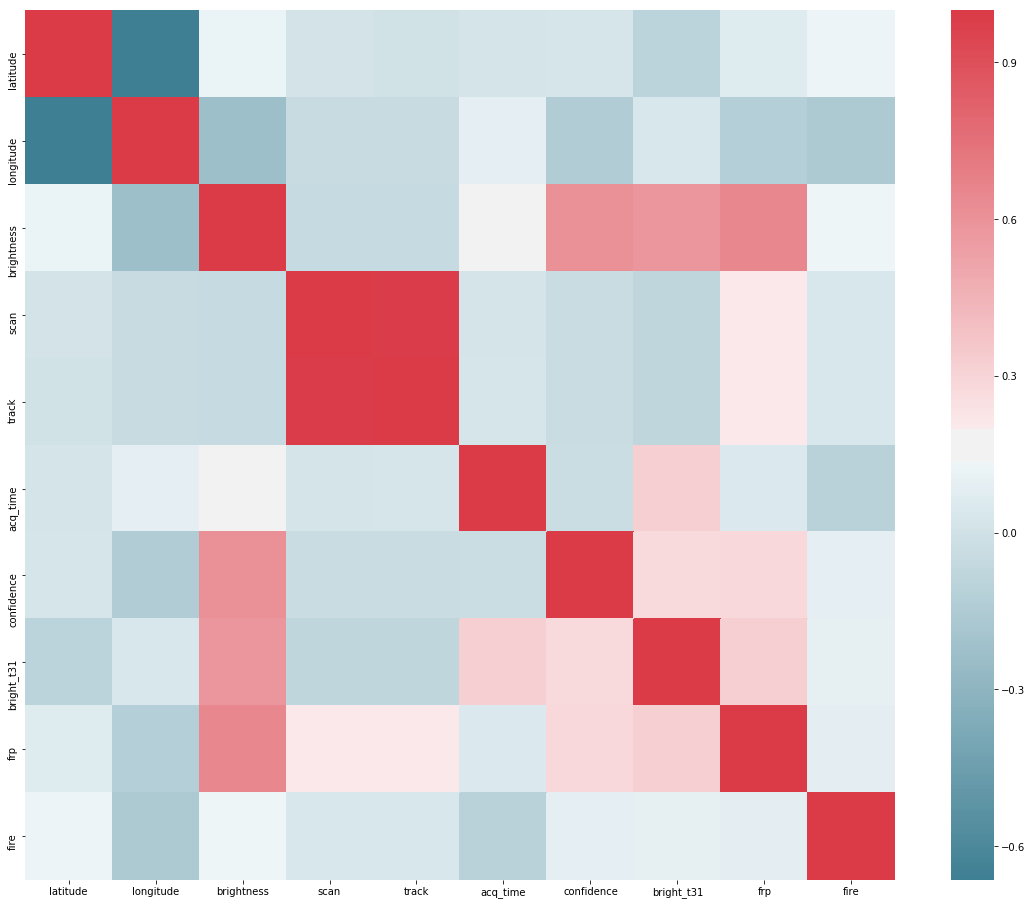

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(20, 16))
corr = labeled_mh.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);

This is a correlation matrix of the saved features, what's interesting is the very low correlation with fire. Low multicolinearity is generally good. However, we can see that the nasa confidence metric is not strongly coorrelated with fire, but is strongly correlated with brightness values, that makes sense as it is a fire classifier derived from brightness, we can keep it as a piece of feature engineering. 

In [38]:
pd.crosstab(index=labeled_mh['acq_date'].dt.year, columns=labeled_mh['fire'], normalize='index')

fire,0.0,1.0
acq_date,,
2001,0.928933,0.071067
2002,0.870388,0.129612
2003,0.846544,0.153456
2004,0.932837,0.067163
2005,0.892640,0.107360
2006,0.864684,0.135316
2007,0.876957,0.123043
2008,0.864794,0.135206
2009,0.898078,0.101922


We can see that the rate of true fires varies between 7% and 15% of the total observations on a yearly basis.

# animation experiments

In [2]:
coords = ['latitude', 'longitude']
mask = (labeled_mh['acq_date'].dt.year == 2001) & (labeled_mh['fire'] == 1)
labeled_mh[mask][coords].values[:,[0]]

years = labeled_mh['acq_date'].dt.year.unique().tolist()
fires = []
for year in years:
        mask = (labeled_mh['acq_date'].dt.year == year) & (labeled_mh['fire'] == 1)
        data = labeled_mh[mask][coords]
        x = data.values[:,[0]]
        y = data.values[:,[1]]
        fires.append({
            'x' : x,
            'y' : y,
            'year' : year
        })

NameError: name 'labeled_mh' is not defined

In [30]:
for fire in fires:
    print(fire["year"])

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


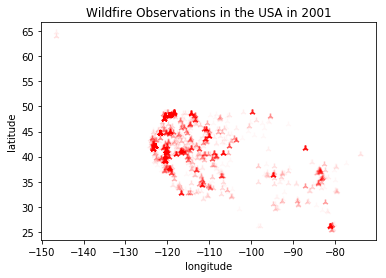

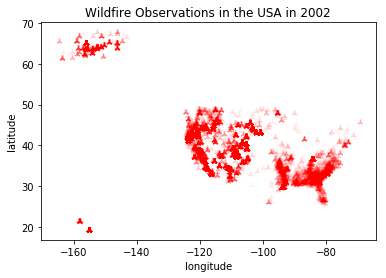

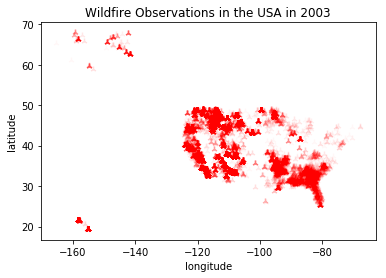

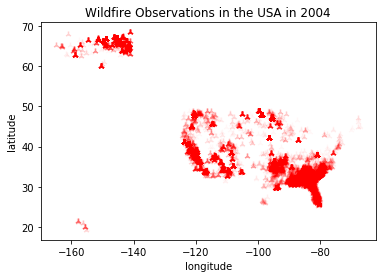

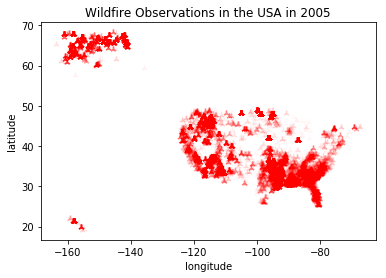

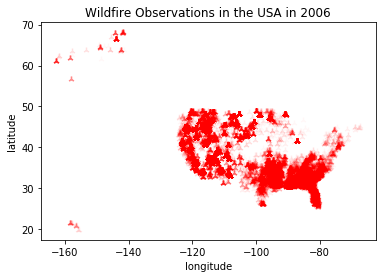

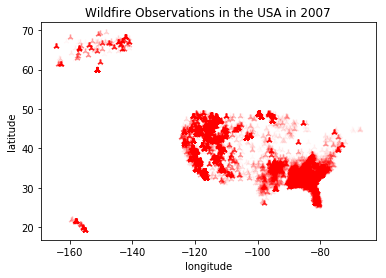

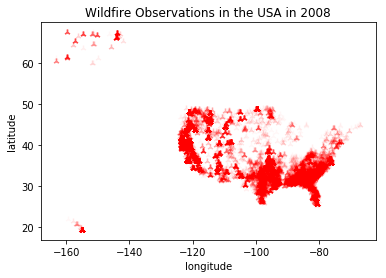

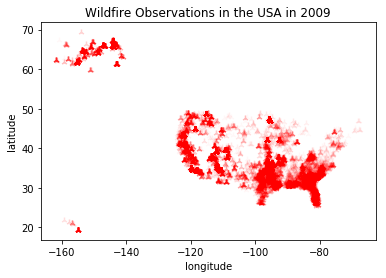

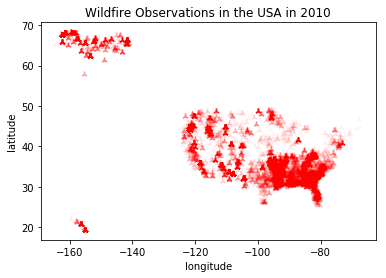

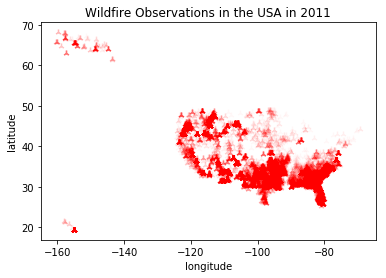

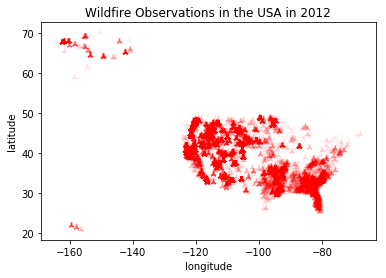

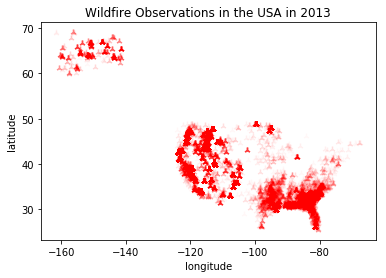

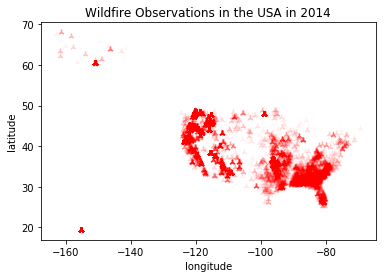

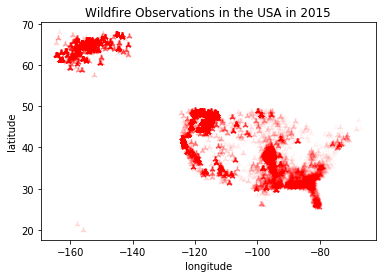

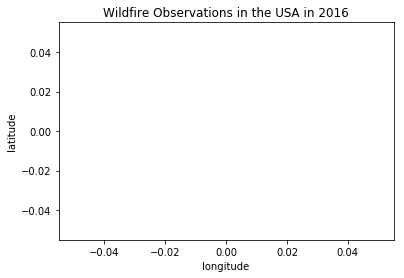

In [33]:
# visualize fire locations
import matplotlib.pyplot as plt


years = labeled_mh['acq_date'].dt.year.unique().tolist()

for fire in fires:
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('Wildfire Observations in the USA in ' + str(fire['year']))
#     plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(fire["y"], fire["x"], alpha=.03, marker="2", color="red")
    plt.show();

In [1]:
fires

NameError: name 'fires' is not defined

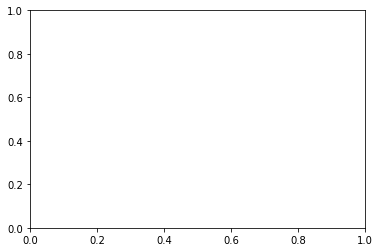

<Figure size 1280x640 with 0 Axes>

In [63]:
import matplotlib.pyplot as plt
from  matplotlib import animation

fig, ax = plt.subplots()
line = ax.plot(x,y)
plt.xlabel('longitude')
plt.ylabel('latitude')

# visualize fire locations

for fire in fires:
    
    plt.title('Wildfire Observations in the USA in ' + str(fire['year']))
#     plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(fire["y"], fire["x"], alpha=.03, marker="2", color="red")
    plt.show();
    

def update(i):
    y = data
    plt.scatter(data["longitude"], data["latitude"], alpha=.3, marker="2", color="red")
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.title('Wildfire Observations in the USA in ', year)
    
    

ani = matplotlib.animation.FuncAnimation(fig, update, frames=60, repeat=True)      
plt.show()

However, the dataset is pretty large, I'm going to downcast it for convenience.

In [39]:
labeled_mh.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1843545 entries, 0 to 1843544
Data columns (total 14 columns):
latitude      float64
longitude     float64
brightness    float64
scan          float64
track         float64
acq_date      datetime64[ns]
acq_time      int64
satellite     object
confidence    int64
version       object
bright_t31    float64
frp           float64
daynight      object
fire          float64
dtypes: datetime64[ns](1), float64(8), int64(2), object(3)
memory usage: 501.9 MB


In [40]:
# memory downcasting system

def float_to_int(ser):
    try:
        int_ser = ser.astype(int)
        if (ser == int_ser).all():
            return int_ser
        else:
            return ser
    except ValueError:
        return ser
    
def all_float_to_int(df):
    df_to_use = df.copy()
    transform_fn = float_to_int
    condition = lambda x: list(x
                    .select_dtypes(include=["float"])
                    .columns)    
    
    return multi_assign(df_to_use, transform_fn, condition)

def multi_assign(df, transform_fn, condition):
    df_to_use = df.copy()
    
    return (df_to_use
        .assign(
            **{col: transform_fn(df_to_use[col])
               for col in condition(df_to_use)})
           )

def downcast_all(df, target_type, inital_type=None):
    #Gotta specify floats, unsigned, or integer
    #If integer, gotta be 'integer', not 'int'
    #Unsigned should look for Ints
    if inital_type is None:
        inital_type = target_type
    
    df_to_use = df.copy()
    
    transform_fn = lambda x: pd.to_numeric(x, 
                                downcast=target_type)
    
    condition = lambda x: list(x
                    .select_dtypes(include=[inital_type])
                    .columns) 
    
    return multi_assign(df_to_use, transform_fn, condition)

labeled_mh = (labeled_mh
     .pipe(all_float_to_int)
     .pipe(downcast_all, "float")
     .pipe(downcast_all, "integer")
     .pipe(downcast_all,  
           target_type = "unsigned", 
           inital_type = "integer")
)

In [41]:
labeled_mh.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1843545 entries, 0 to 1843544
Data columns (total 14 columns):
latitude      float32
longitude     float32
brightness    float32
scan          float32
track         float32
acq_date      datetime64[ns]
acq_time      uint16
satellite     object
confidence    uint8
version       object
bright_t31    float32
frp           float32
daynight      object
fire          uint8
dtypes: datetime64[ns](1), float32(7), object(3), uint16(1), uint8(2)
memory usage: 417.6 MB


This reduced memory usage by over 100mb so pretty cool. I will now save this dataframe for use in model training.

In [42]:
# I'll save merged now
labeled_mh.to_pickle('/home/nedderlander/datascience/burn notice/Data-Science/Data/Cleaned_Modus_Historical/labeled_mh_r1_v2.pkl')